# Model Inspection aka Interpretable Machine Learning

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_log_error
from sklearn import tree
from IPython.display import Image  
from sklearn.inspection import PartialDependenceDisplay
from sklearn.base import is_classifier, is_regressor
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn import tree
from IPython.display import Image  
from numpy import linalg
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from time import time
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
import random

def kaggle_score(y_true,y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred));
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Tree Models

### Feature Importances

Let us first look at feature importances in the bank marketing dataset



In [10]:
# Bank Marketing Dataset from
# https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

bank = pd.read_csv("../datasets/bank/bank-full.csv", delimiter = ";")
#bank = pd.read_csv("bank-full.csv", delimiter = ";")
# print first 5 examples
bank.head(5)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [2]:
bank.shape

NameError: name 'bank' is not defined

In [ ]:
bank.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [ ]:
bank_majority = bank[bank.y=="no"]
bank_minority = bank[bank.y=="yes"]
 
# downsample
bank_majority_downsampled = resample(bank_majority, 
                                 replace=False,    
                                 n_samples=5289) 
 
bank_balanced = pd.concat([bank_minority, bank_majority_downsampled])
bank_balanced.y.value_counts()

yes    5289
no     5289
Name: y, dtype: int64

In [ ]:
X = bank_balanced.loc[:,'age':'poutcome']
X["random_num"] = np.random.rand(X.shape[0])
X.drop(columns=['duration'], inplace=True)

y = bank_balanced.loc[:,'y']
y = y.replace(["yes","no"],[1,0])
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
 
   

clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train);

y_pred1 = clf.predict(X_test)  

print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.65      0.83      0.73       529
           1       0.76      0.55      0.64       529

    accuracy                           0.69      1058
   macro avg       0.70      0.69      0.68      1058
weighted avg       0.70      0.69      0.68      1058



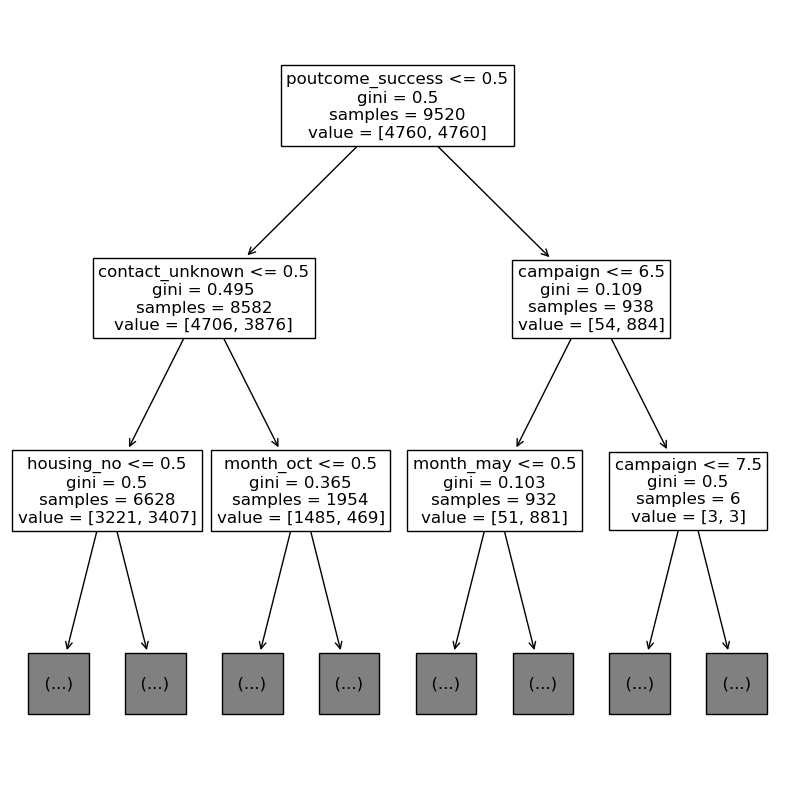

In [ ]:
plt.figure(figsize=(10,10));
tree.plot_tree(clf, feature_names=X.columns,max_depth=2, fontsize=12);

### Feature importance scores

Total reduction in impurity brought by the feature (for categorical classes) and total reduction in variance brought by the feature (for numerical classes). Impurity-based feature importances can be misleading for high cardinality features.

In [ ]:
imps = clf.feature_importances_
sorted_idx = np.argsort(imps)[::-1]
sorted_vals = np.sort(imps)[::-1]

d = {"features":X.columns[sorted_idx], "values":sorted_vals}
pd.DataFrame(d)

,features,values
0,poutcome_success,0.415096
1,contact_unknown,0.231723
2,housing_no,0.102297
3,month_aug,0.072493
4,month_jul,0.051847
5,campaign,0.038593
6,pdays,0.023423
7,month_mar,0.022930
8,month_oct,0.014420
9,month_nov,0.008736


### sklearn tree structure

The entire binary tree structure is represented as a number of parallel arrays. The i-th element of each array holds information about the node i. Node 0 is the tree’s root. Nunbers are assigned in a depth-first order.

Some of these are:

- children_left[i]: id of the left child of node i or -1 if leaf node

- children_right[i]: id of the right child of node i or -1 if leaf node

- feature[i]: feature used for splitting node i

- threshold[i]: threshold value at node i

- n_node_samples[i]: the number of training samples reaching node i

- impurity[i]: the impurity at node i

For more information:
[sklearn tree structure](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html)

### Feature importances from scratch

In [ ]:
def MyFeatureImportance(tree, idx, imps):
    """
    :tree: Decision tree built
    :idx: Index of the root of the subtree that the importances will be calculated.
    :imps: feature importances, should be initialized to all zeros 
    :return: imps
    """
    if tree.children_left[idx] > -1:
        imps[tree.feature[idx]]+=(tree.n_node_samples[idx]*tree.impurity[idx] 
        - tree.n_node_samples[tree.children_left[idx]]*tree.impurity[tree.children_left[idx]]
        - tree.n_node_samples[tree.children_right[idx]]*tree.impurity[tree.children_right[idx]])
        
        MyFeatureImportance(tree, tree.children_left[idx], imps)
        MyFeatureImportance(tree, tree.children_right[idx], imps)
        
    return imps/np.sum(imps)

Now, let us check my_feature_importance finds the same importance values as sklearn

In [ ]:
my_imps = np.zeros(clf.n_features_in_)
my_imps = MyFeatureImportance(clf.tree_,0, my_imps)
my_sorted_idx = np.argsort(my_imps)[::-1]
my_sorted_vals = np.sort(my_imps)[::-1]

d = {"features":X.columns[my_sorted_idx], "values":my_sorted_vals, "sklearn features":X.columns[sorted_idx], "sklearn values":sorted_vals}
pd.DataFrame(d)

,features,values,sklearn features,sklearn values
0,poutcome_success,0.415096,poutcome_success,0.415096
1,contact_unknown,0.231723,contact_unknown,0.231723
2,housing_no,0.102297,housing_no,0.102297
3,month_aug,0.072493,month_aug,0.072493
4,month_jul,0.051847,month_jul,0.051847
5,campaign,0.038593,campaign,0.038593
6,pdays,0.023423,pdays,0.023423
7,month_mar,0.022930,month_mar,0.022930
8,month_oct,0.014420,month_oct,0.014420
9,month_nov,0.008736,month_nov,0.008736


Let us now look at house price prediction dataset

In [ ]:
# Run Regression Tree with top correlated 10 attributes with SalePrice

train = pd.read_csv("../datasets/house_prices/train.csv")
#train = pd.read_csv("train.csv")
#test = pd.read_csv("../datasets/house_prices/test.csv")

cors = train.corr(); 
top10 = cors.loc[:, "SalePrice"].sort_values(ascending = False).head(11)
top10 = top10.index.values.tolist()
top10.pop(0)

X = train.loc[:,top10]
y = train.loc[:,'SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    #X_train = X_train.fillna(X_train.mean())
    #X_test = X_test.fillna(X_test.mean())
regr = DecisionTreeRegressor()
model = regr.fit(X_train, y_train)
test_predictions = model.predict(X_test)
print("Test MAE:", mean_absolute_error(y_test, test_predictions))



Test MAE: 23316.19178082192


In [ ]:
imps = regr.feature_importances_
sorted_idx = np.argsort(imps)[::-1]
sorted_vals = np.sort(imps)[::-1]



my_imps = np.zeros(regr.n_features_in_)
my_imps = MyFeatureImportance(regr.tree_,0, my_imps)
my_sorted_idx = np.argsort(my_imps)[::-1]
my_sorted_vals = np.sort(my_imps)[::-1]

d = {"features":X.columns[my_sorted_idx], "values":my_sorted_vals, "sklearn features":X.columns[sorted_idx], "sklearn values":sorted_vals}
pd.DataFrame(d)

,features,values,sklearn features,sklearn values
0,OverallQual,0.649104,OverallQual,0.649104
1,GrLivArea,0.127651,GrLivArea,0.127651
2,TotalBsmtSF,0.058695,TotalBsmtSF,0.058695
3,YearRemodAdd,0.044066,YearRemodAdd,0.044066
4,GarageArea,0.033477,GarageArea,0.033477
5,1stFlrSF,0.029145,1stFlrSF,0.029145
6,GarageCars,0.025227,GarageCars,0.025227
7,YearBuilt,0.022270,YearBuilt,0.022270
8,TotRmsAbvGrd,0.007253,TotRmsAbvGrd,0.007253
9,FullBath,0.003113,FullBath,0.003113


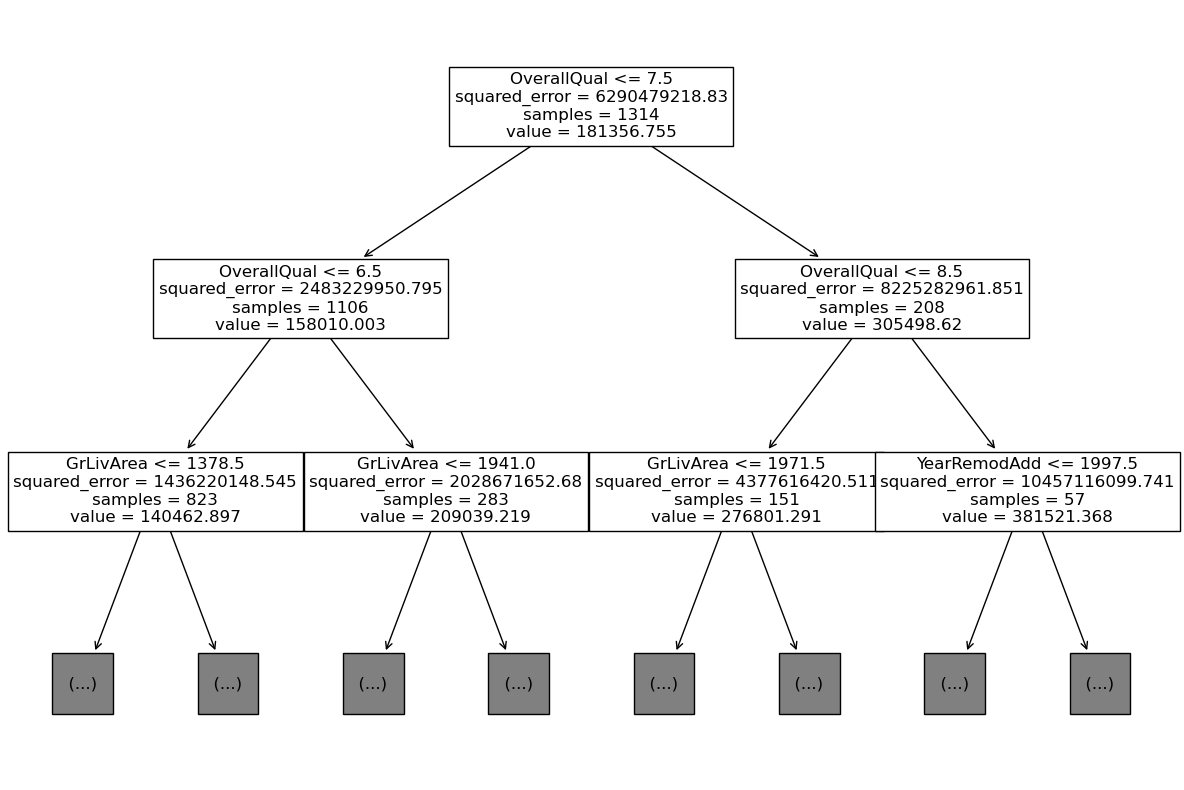

In [ ]:
plt.figure(figsize=(15,10));
tree.plot_tree(regr, feature_names=X.columns,max_depth=2, fontsize=12);

### Discussion

- Feature importance scores are computed on the model which is fitted on the training set, therefore if a model overfits than the scores can be misleading. You can try to add a random feature to see this result.
- It is better to evaluate the importance of a feature on the test set. Permutation importance can help at this point.
- It is important not to forget that these scores only show the importance of a feature relative to a model. In other words how much a model relies on a feature. A feature which might not be used by a model does not mean that that feature is unimportant in general. This might happen, for example, when there are two important but correlated features. A decision tree will choose one of them and will not use the other one. This does not mean that the unused feature is not important in general.
- Permutation feature importance requires the true labels in addition to the model.
- Correlated features might create problems. Suppose that feature A is very important, if you add a correlated feature B, and then train a random forest, then some of the trees will use feature A and some of the trees will use feature B. As a result, the importance of these features will decrease.

### Permutation Importance

Permutation importance of a feature in the decrease in model score when the values of that feature are randomly shuffled.

In [ ]:
X = bank_balanced.loc[:,'age':'poutcome']
X["random_num"] = np.random.rand(X.shape[0])
X.drop(columns=['duration'], inplace=True)

y = bank_balanced.loc[:,'y']
y = y.replace(["yes","no"],[1,0])
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
 
clf = RandomForestClassifier()
clf.fit(X_train, y_train);

y_pred1 = clf.predict(X_test)  

print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.70      0.77      0.73       531
           1       0.74      0.67      0.71       527

    accuracy                           0.72      1058
   macro avg       0.72      0.72      0.72      1058
weighted avg       0.72      0.72      0.72      1058



In [ ]:
X.shape

(10578, 51)

In [ ]:
perm_test = permutation_importance(clf, X_test, y_test)
perm_train = permutation_importance(clf, X_train, y_train)

KeyboardInterrupt: 

In [ ]:
imps = clf.feature_importances_
sorted_idx = np.argsort(imps)[::-1]
sorted_vals = np.sort(imps)[::-1]

perm_imps_test = perm_test['importances_mean']
perm_sorted_idx_test = np.argsort(perm_imps_test)[::-1]
perm_sorted_vals_test = np.sort(perm_imps_test)[::-1]

perm_imps_train = perm_train['importances_mean']
perm_sorted_idx_train = np.argsort(perm_imps_train)[::-1]
perm_sorted_vals_train = np.sort(perm_imps_train)[::-1]

d = {"Perm. features Test":X.columns[perm_sorted_idx_test], "Perm. Imp. Test":perm_sorted_vals_test,"Perm. features Train":X.columns[perm_sorted_idx_train], "Perm. Imp.Train":perm_sorted_vals_train, "Feature Imp. features":X.columns[sorted_idx], "Feature Imp.":sorted_vals}
pd.DataFrame(d)

### Partial Dependency Plots (PDPs)

Sometimes we might want to understand the effect of a single feature on the output variable. In particular how does the output variable change as the input variable changes (increases and decreases)?

If we have the true function relating x to y then we can fulfill this aim. The function can be simple, complex or multivariate.

If $y = x$, then it is easy to describe the behavior of y as x changes: there is a positive linear relationship. What about $y = x + x^2 + 20x^3 - x^4$? 

Well, the derivative of y with respect to x is not the same for all values of x which means that the behavior of y as x changes differs depending on the value of x. 

When we have two variables we can still use visualization (contour or mesh plots) in order to understand the effect of the change in the variables on the output variable. However, for higher dimensional functions visualization is not possible. One possible solution is called Partial Dependendence Plots (PDPs) proposed by Friedman (2001) in his seminal gradient boosting machines paper. The reason was that, gradient boosting, unlike single decision trees, create models consisting of many trees (sometimes hundreds of trees). And it is almost impossible to understand the function represented by these trees. 

Suupose that we have $n$ variables $X = {x_1, x_2, ..., x_n}$ and $X_S = {x_1, x_2, ..., x_l}$ and $X_C = X  \backslash  X_S$. Then the partial dependence of the response $f$ at a point $X_S$ is given by:
$$
pd(X_S) = E_{X_C}[f(X_S, X_C)] = \int f(X_S,X_C)dP(X_C)
$$

We can estimate the function as follows:

$$
pd(X_S) = \frac{1}{m}\sum_{i=1}^mf(X_S,X_C^{(i)})
$$


In [168]:
def foo(x):
    return x + x**2 + 20*x**3 - x**4

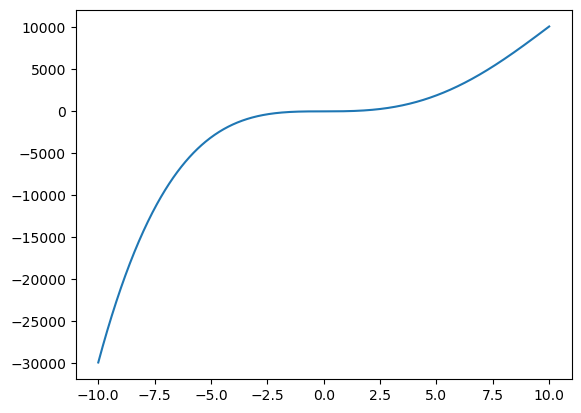

In [169]:
x = np.linspace(-10, 10, 1000)
y = foo(x)
plt.plot(x, y);

How can a similar plot can be drawn for the following multivariate function? That is, how can we plot how y varies as we vary x?

In [170]:
def foo2(x,y,z):
    return x + y**2 + 20*x**3 - y**4

### Regression Problem - Bike Sharing Dataset

ValueError: x, y, and format string must not be None

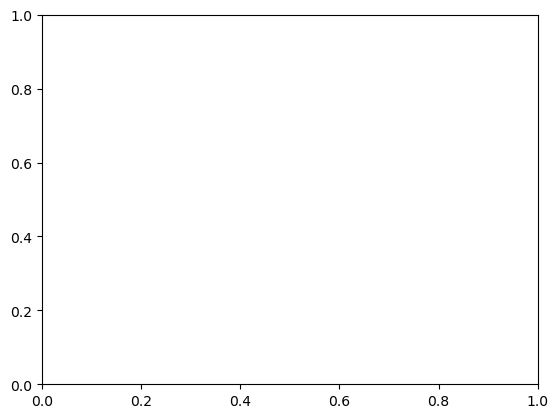

In [156]:
import matplotlib.pyplot as plt
import numpy as np

# Define the function you want to plot
def f(x):
    return x**2

# Generate some x values to plot over
x = np.linspace(-10, 10, 1000)

# Evaluate the function for each x value
y = foo(x)

# Plot the function
plt.plot(x, y)

# Add labels and a title
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x) = x^2')

# Show the plot
plt.show()


In [125]:
from sklearn.datasets import fetch_openml

bikes = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas")
# Make an explicit copy to avoid "SettingWithCopyWarning" from pandas
X, y = bikes.data.copy(), bikes.target


In [126]:
X.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0


In [127]:
y.head()

0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [128]:
X["weather"].value_counts()

clear         11413
misty          4544
rain           1419
heavy_rain        3
Name: weather, dtype: int64

In [129]:
X["weather"].replace(to_replace="heavy_rain", value="rain", inplace=True)

In [130]:
mask_training = X["year"] == 0.0
X = X.drop(columns=["year"])
X_train, y_train = X[mask_training], y[mask_training]
X_test, y_test = X[~mask_training], y[~mask_training]

In [131]:
numerical_features = [
    "temp",
    "feel_temp",
    "humidity",
    "windspeed",
]
categorical_features = X_train.columns.drop(numerical_features)


In [132]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    sparse_threshold=1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")
preprocessor

ColumnTransformer(sparse_threshold=1,
                  transformers=[('cat', OrdinalEncoder(),
                                 Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object')),
                                ('num', 'passthrough',
                                 ['temp', 'feel_temp', 'humidity',
                                  'windspeed'])],
                  verbose_feature_names_out=False)

In [133]:
from sklearn.ensemble import HistGradientBoostingRegressor

print("Training HistGradientBoostingRegressor...")
tic = time()
hgbdt_model = make_pipeline(
    preprocessor,
    HistGradientBoostingRegressor(
        categorical_features=categorical_features, random_state=0
    ),
)
hgbdt_model.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {hgbdt_model.score(X_test, y_test):.2f}")

Training HistGradientBoostingRegressor...
done in 0.673s
Test R2 score: 0.64


Computing partial dependence plots...
done in 8.819s


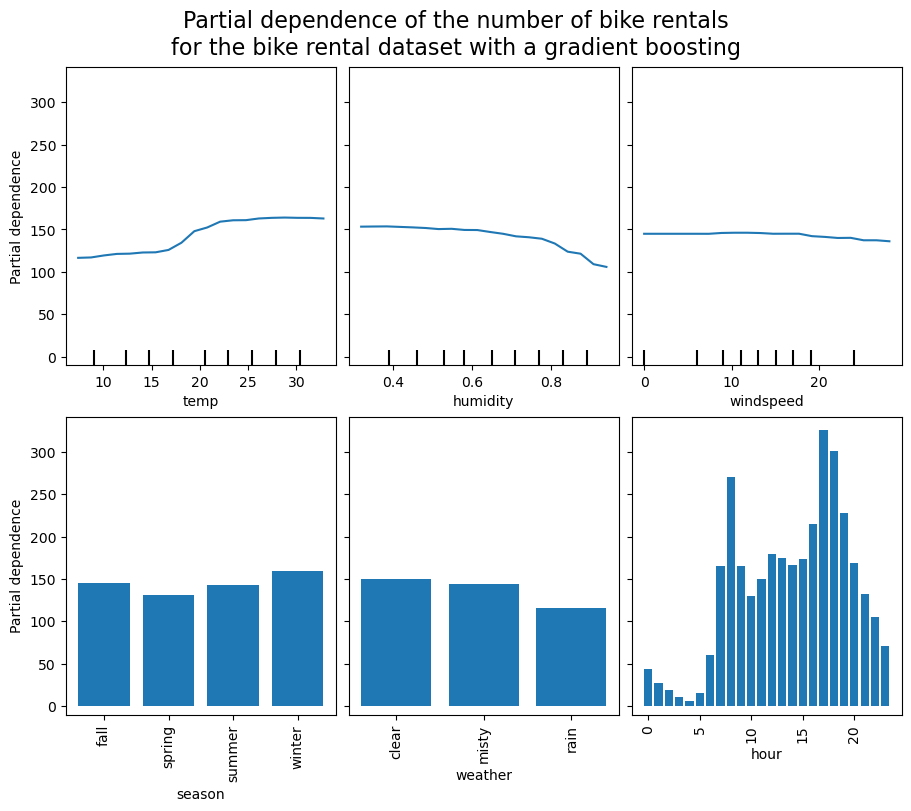

In [134]:
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}
features_info = {
    # features of interest
    "features": ["temp", "humidity", "windspeed", "season", "weather", "hour"],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": categorical_features,
}
print("Computing partial dependence plots...")
tic = time()
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "Partial dependence of the number of bike rentals\n"
    "for the bike rental dataset with a gradient boosting",
    fontsize=16,
)

Computing partial dependence plots and individual conditional expectation...
done in 3.887s


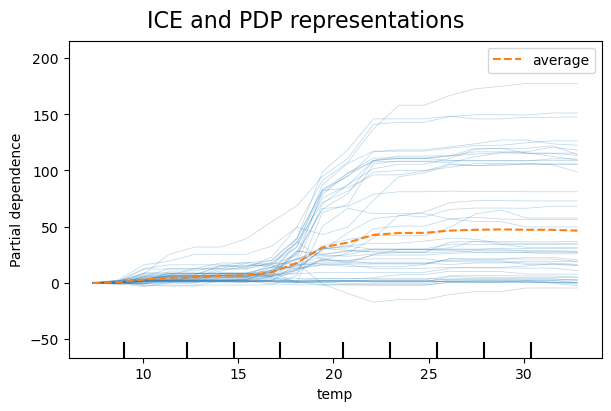

In [135]:
print("Computing partial dependence plots and individual conditional expectation...")
tic = time()
_, ax = plt.subplots(ncols=1, figsize=(6, 4), sharey=True, constrained_layout=True)

features_info = {
    "features": ["temp"],
    "kind": "both",
    "centered": True,
}

display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle("ICE and PDP representations", fontsize=16)

In [123]:
def MyPartialDependencePlot(model, X, feature_idx, n_points=100, categorical=False, percentiles=(0.05,0.95), kind="average", target=1, alpha = 0.3, subsample=50):
    
    y = X.iloc[:,feature_idx]
    if categorical == False:
        min_value = np.percentile(y,100*percentiles[0])
        max_value = np.percentile(y,100*percentiles[1])
    #print(min_value)
    #print(max_value)
    if (len(y.unique()) < n_points):
        x_range = np.sort(y.unique())
    else:
        step_size = (max_value-min_value)/n_points
        x_range = range(int(min_value), int(max_value), int(step_size))
        
    range_length = len(x_range)
    avgs = []
    inds = np.zeros((len(y),range_length))
    x = []
    if categorical == False:
        y = y[(y>=min_value) & (y<=max_value)]
    
    x_idx=0
    for i in x_range:
        # set all the column values to i and make predictions. This generates the response of the model for
        # all variations of the other features' values that are in the dataset.
        X.iloc[:,feature_idx] = i
        if (is_classifier(model)):
            preds = model.predict_proba(X)[:,target]
        else:
            preds = model.predict(X)
        avgs.append(np.mean(preds))
        inds[:,x_idx]=preds
        x.append(i)
        x_idx += 1
    if kind=="average" or kind=="both":
        plt.plot(x,avgs)
    if kind=="individual" or kind=="both":
        ice_lines_idx = random.sample(
            range(inds.shape[0]),
            subsample
        )
        for i in ice_lines_idx:
            plt.plot(x,inds[i],color="k",linewidth=0.5, alpha=alpha)
    ax = plt.gca()
    diff = max(avgs) - min(avgs)
    if categorical == False:
        deciles = np.percentile(y, np.arange(0, 100, 10))
        ax.vlines(deciles, min(avgs), min(avgs)+diff*0.05,color="k")
    #plt.ylim(min(avgs), max(avgs))
    plt.xlabel(X.columns[feature_idx])


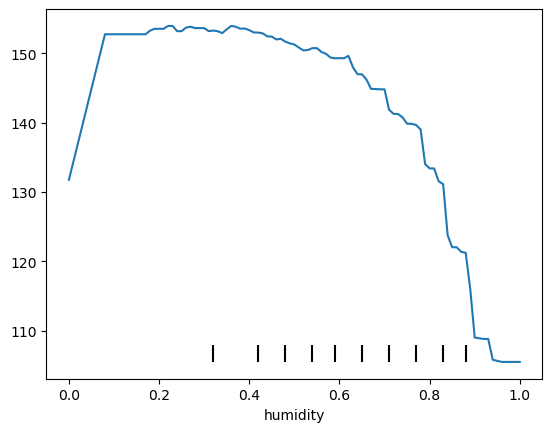

In [138]:
A = X_train.copy()
MyPartialDependencePlot(hgbdt_model, A, 9, 100, kind="average")

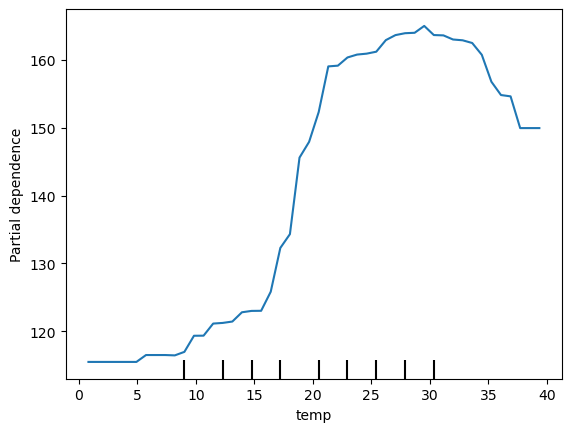

In [95]:
PartialDependenceDisplay.from_estimator(hgbdt_model,X_train,[7], kind='average');

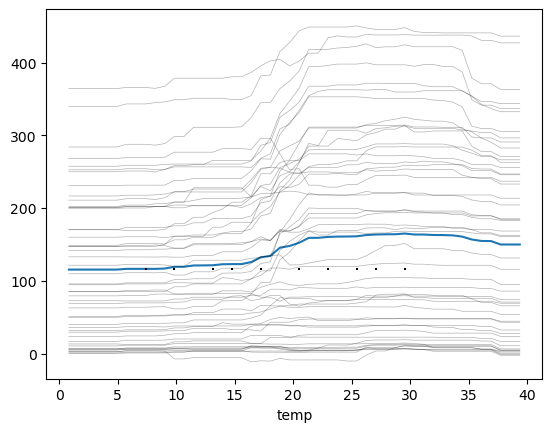

In [43]:
A = X_train.copy()
x, inds = MyPartialDependencePlot(hgbdt_model, A, 7, 100, kind="both")

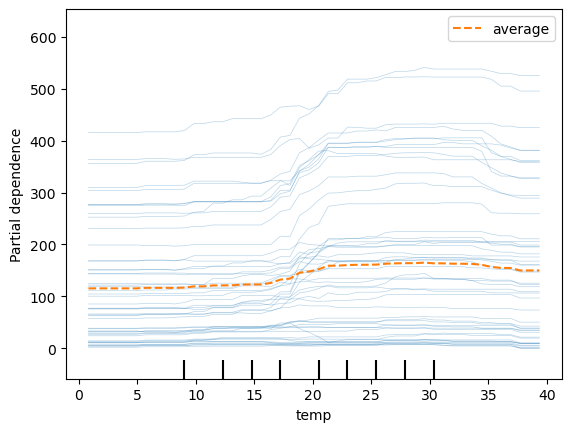

In [137]:
PartialDependenceDisplay.from_estimator(hgbdt_model,X_train,[7], subsample= 50,centered=False,kind='both', random_state=0);

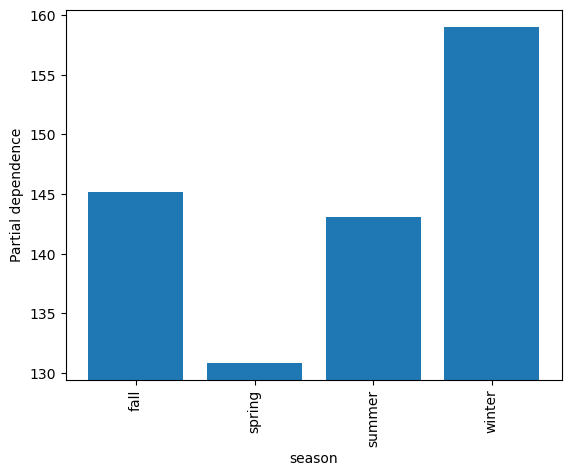

In [61]:
PartialDependenceDisplay.from_estimator(hgbdt_model,X_train,[0], categorical_features=[0]);

In [ ]:
MyPartialDependencePlot(hgbdt_model,X_train,0, categorical=True);

### Classification Problem - Adult Dataset

In [139]:
adult = pd.read_csv("../datasets/adult/adult.csv", delimiter=",", skipinitialspace=True)
adult.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [140]:
adult.y.value_counts()

<=50K    24720
>50K      7841
Name: y, dtype: int64

In [141]:
adult_majority = adult[adult.y=="<=50K"]
adult_minority = adult[adult.y==">50K"]
 
# downsample
adult_majority_downsampled = resample(adult_majority, 
                                 replace=False,    
                                 n_samples=7841) 
 
adult_balanced = pd.concat([adult_minority, adult_majority_downsampled])
adult_balanced.y.value_counts()

>50K     7841
<=50K    7841
Name: y, dtype: int64

In [142]:
#y = y.replace(["yes","no"],[1,0])
#X = pd.get_dummies(X)
oe = OrdinalEncoder()
data = oe.fit_transform(adult_balanced)
encoded = pd.DataFrame(data = data, columns = adult_balanced.columns)
X = encoded.loc[:,'age':'native-country']
y = encoded.loc[:,'y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = DecisionTreeClassifier()
#clf = RandomForestClassifier()
clf.fit(X_train, y_train);

y_pred1 = clf.predict(X_test)  

print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75       786
         1.0       0.75      0.74      0.75       783

    accuracy                           0.75      1569
   macro avg       0.75      0.75      0.75      1569
weighted avg       0.75      0.75      0.75      1569



In [117]:
X.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,35.0,6.0,7630.0,11.0,8.0,2.0,4.0,0.0,4.0,1.0,0.0,0.0,44.0,38.0
1,14.0,4.0,729.0,12.0,13.0,4.0,10.0,1.0,4.0,0.0,90.0,0.0,49.0,38.0
2,25.0,4.0,4644.0,9.0,12.0,2.0,4.0,0.0,4.0,1.0,67.0,0.0,39.0,38.0
3,20.0,4.0,9674.0,15.0,9.0,2.0,4.0,0.0,2.0,1.0,0.0,0.0,76.0,38.0
4,13.0,7.0,3886.0,9.0,12.0,2.0,10.0,0.0,1.0,1.0,0.0,0.0,39.0,18.0


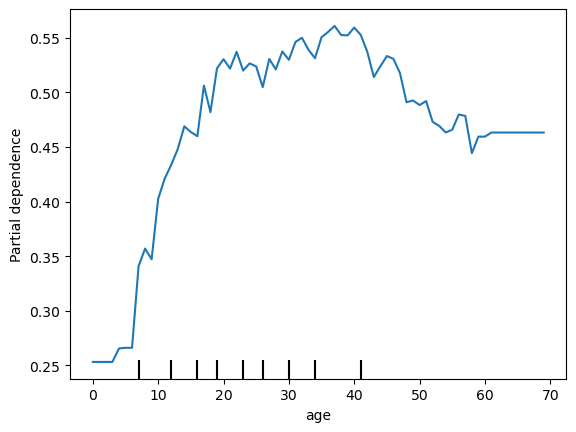

In [143]:
PartialDependenceDisplay.from_estimator(clf,X_train,[0], target=1);

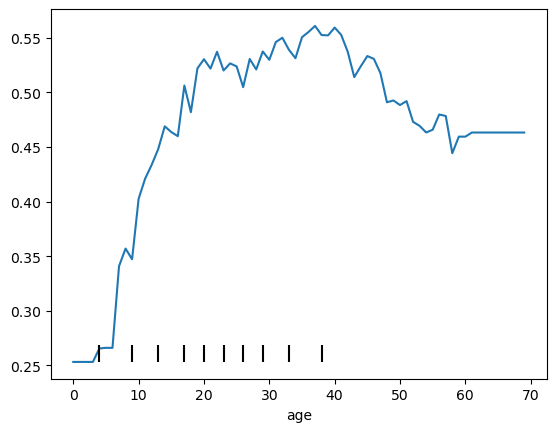

In [144]:
A = X_train.copy()
MyPartialDependencePlot(clf, A, 0, kind="average")

### Individual conditional expectation (ICE) plot